## Faulty VS Nonfaulty
This file aims to document the process of finding ways to do Faulty vs nonfaulty classification and afterwards classifing the faulty data. 

In this document the following is tested:

- SVM in 11 dimensions (failiur)
- LDA, 2 classes --> 1 dimension LDA classification (failiur)
- LDA - MLC (Failiur)
- MLC in 11 dimensions (failiur, overfitting)

In [3]:
#import libraries
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import linalg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

import pandas as pd

import os

# Set correct working directory
if os.getcwd() != os.path.abspath("../Python"):
    os.chdir("../../Python")

import standardization as sd                                #Self written, Scikit-learn do have standardScaler which does the same.
import confusion_matrix
import confusion_matrix2

from sklearn import svm

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmr"
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load training data
train_data = pd.read_csv("../TrainingData/neodata/fault_all_nonoise_67.csv")
val_data = pd.read_csv("../ValidationData/neodata/fault_all_nonoise_67.csv")
test_data = pd.read_csv("../TestData/neodata/fault_all_nonoise_67.csv")
#train_data.head()

## Classification faulty vs non faulty using SVM
At first the targets are set to one for all faulty data.

In [5]:
train_data1 = train_data.copy()                                 #Pandas dataframe: Use copy if copy of the dataframe and not just the indexes
train_data1.loc[train_data['target']!=0,'target'] = 1

val_data1 = val_data.copy()
val_data1.loc[val_data1['target']!=0,'target'] = 1

test_data1 = test_data.copy()
test_data1.loc[test_data['target']!=0,'target'] = 1

standardizer1 = sd.standardization(train_data1,'target')
trn1 = standardizer1.transform(train_data1)
val1 = standardizer1.transform(val_data1)
tst1 = standardizer1.transform(test_data1)

print(type(train_data1))


<class 'pandas.core.frame.DataFrame'>


In [9]:
clf_SVM = svm.SVC( kernel="rbf", decision_function_shape="ovo", C=1000, gamma=0.01)
clf_SVM.fit(trn1.drop('target',axis=1), trn1['target'])

SVC(C=1000, decision_function_shape='ovo', gamma=0.01)

In [10]:
#predicting
predict1 = clf_SVM.predict(trn1.drop('target',axis=1))

print(trn1['target'].to_numpy())
print(predict1)

[1 1 1 ... 0 0 0]
[0 1 1 ... 0 0 0]


(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Training data : Accuracy 78.969%'}, xlabel='Predicted class', ylabel='True class'>)

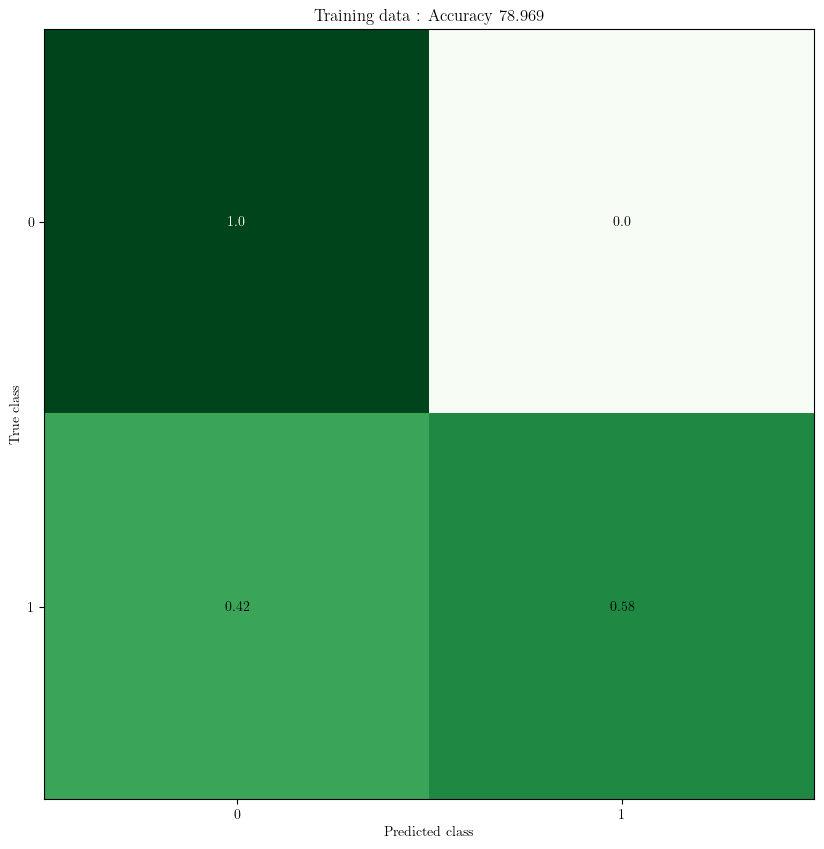

In [11]:

conf_matrix = np.zeros([2, 2])

for x,y in zip(predict1,trn1['target']):
    conf_matrix[int(y)][int(x)] +=1

    #Generate confusion matrix pdf
confusion_matrix.confusion_matrix(conf_matrix, figsize = (10,10), title = 'Training data',eval_labels = False)


The above result clearly shows that the SVM Failed to classify faulty and non faulty data. Lets try to set the number of faulty and non-faulty sampels in the training set equal and see if it improves

In [12]:
train_data_fault = train_data.loc[train_data['target']!=0]
train_data_fault2 = train_data_fault.sample(1200)                   #Taking 1200 sampels of the faulty data
train_data_fault2['target'] = 1                                     #Setting target to 1

train_data_NoFault = train_data.loc[train_data['target']==0]        #Taking 1200 sampels of non-faulty
train_data_NoFault2 = train_data_NoFault.copy()

train_data2 = pd.concat([train_data_fault2,train_data_NoFault2])

standardizer1 = sd.standardization(train_data2,'target')
trn1 = standardizer1.transform(train_data2)
tst1 = standardizer1.transform(test_data1)

In [13]:
#predicting
clf_SVM_equal = svm.SVC( kernel="rbf", decision_function_shape="ovo", C=1000, gamma=1)

clf_SVM_equal.fit(trn1.drop(['target'],axis=1),trn1['target'])
predict1tst = clf_SVM_equal.predict(tst1.drop('target',axis=1))

print(trn1['target'].to_numpy())
print(predict1)

[1 1 1 ... 0 0 0]
[0 1 1 ... 0 0 0]


(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Confusion matrix : Accuracy 95.238%'}, xlabel='Predicted class', ylabel='True class'>)

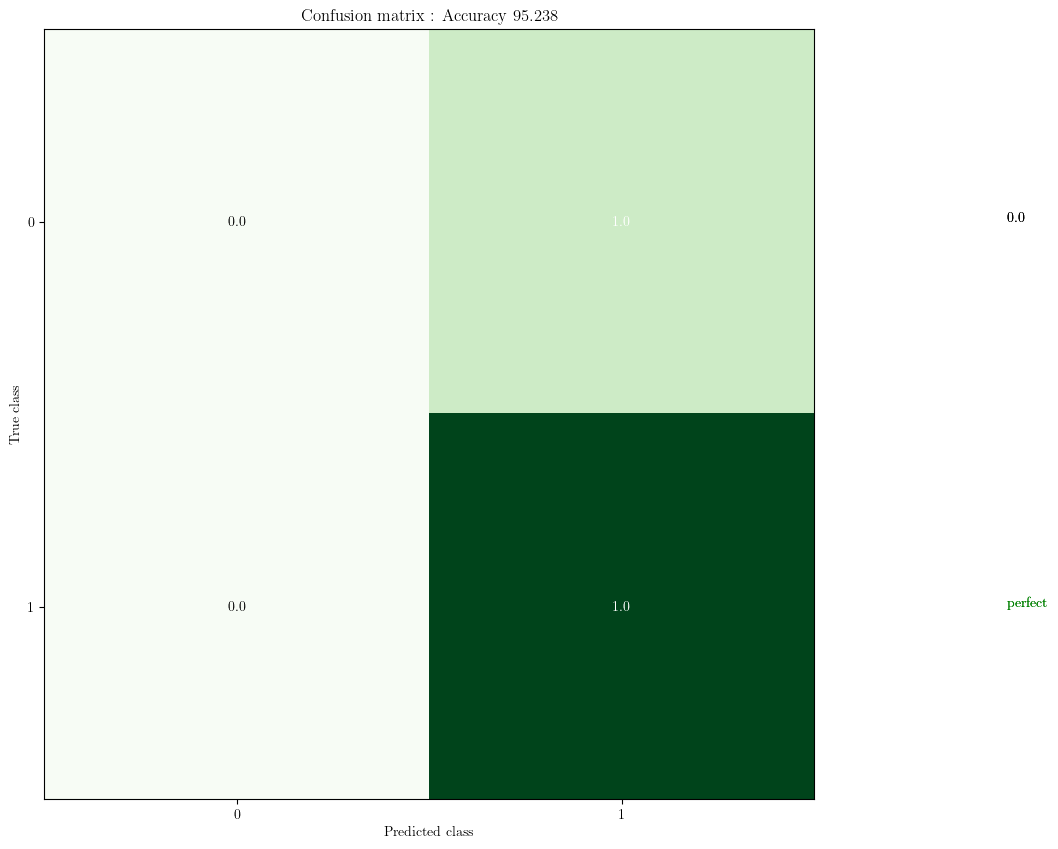

In [14]:
confusion_matrix2.confusion_matrix(tst1['target'],predict1tst)

The result is no improvement. It is concluded that this does not work for SWM.

## Lets try LDA
Out of the box from Scikit learn

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [16]:
X=train_data2.drop('target',axis=1)
Y=train_data2['target']

clf = LDA()
clf.fit(X,Y)

LinearDiscriminantAnalysis()

In [17]:
Y_predict = clf.predict(X)

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Confusion matrix : Accuracy 69.534%'}, xlabel='Predicted class', ylabel='True class'>)

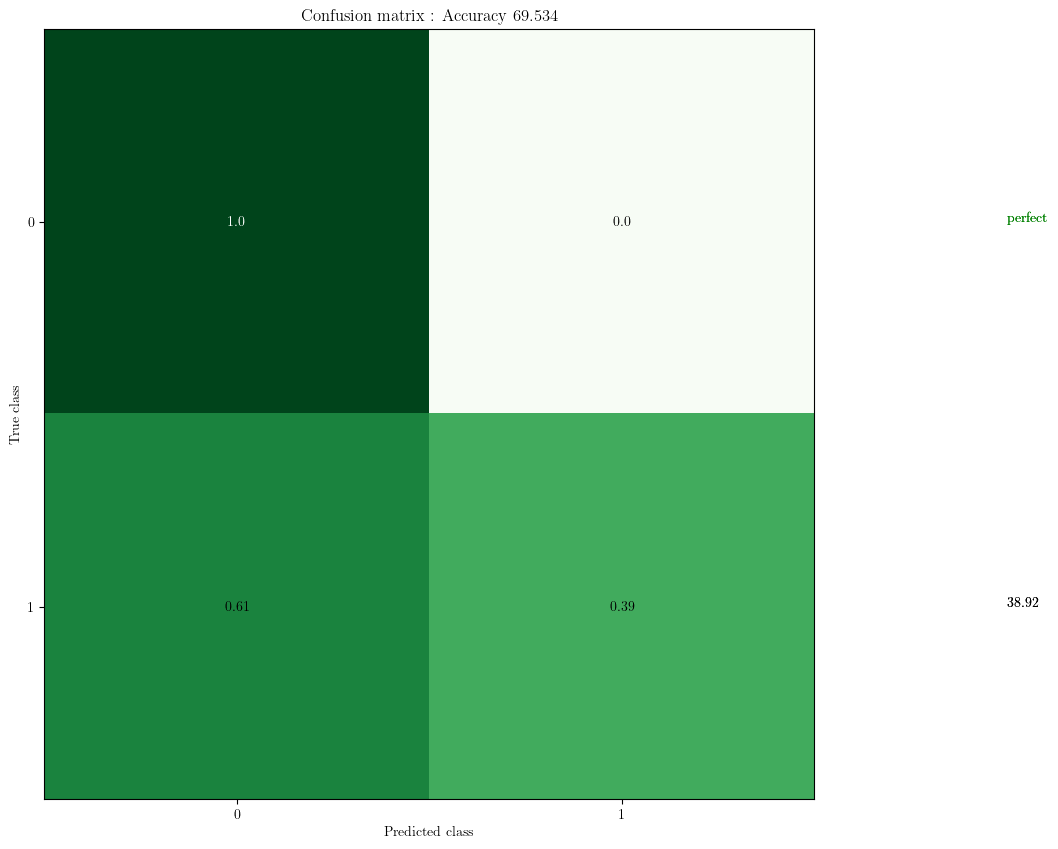

In [18]:
conf_matrix = np.zeros([2, 2])

confusion_matrix2.confusion_matrix(Y,Y_predict)

The result is poor predeictions for both the equal amount dataset and the full dataset. This has an issue with false positives

## Lets try to plot the data transformed into one dimension

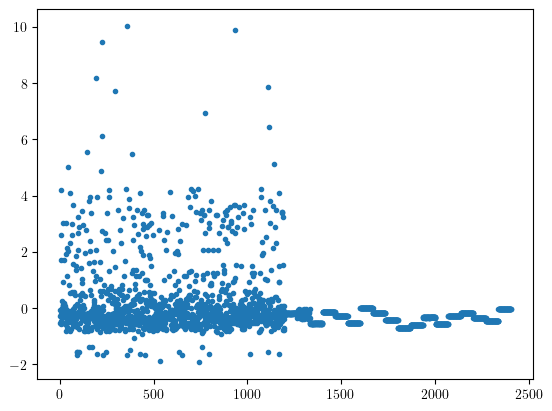

In [20]:
X_dim = clf.transform(X)

plt.plot(X_dim,'.')

It is pretty clear that this is hard to classify. The best option might be MLC. Lets try it just on the NON-transformed data.

## MLC On the transformed data

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Training data : Accuracy 71.613%'}, xlabel='Predicted class', ylabel='True class'>)

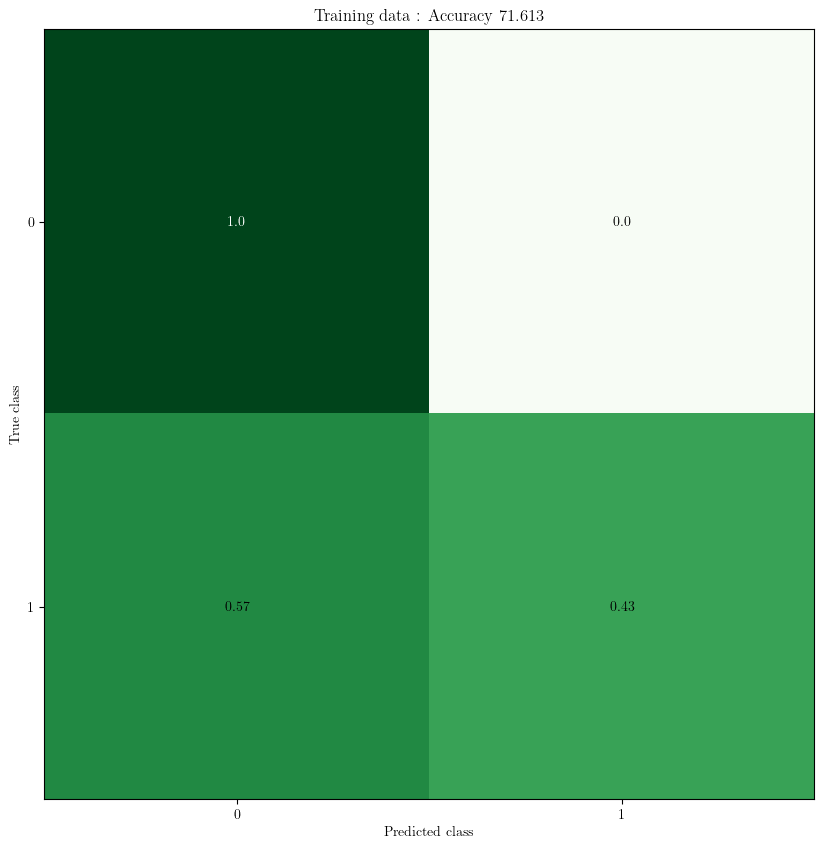

In [21]:
import python_bayes as bay

#X_tst = test_data1.drop(['target'],axis=1)
#Y_tst = test_data1['target']

clf1dim = bay.classifier()
clf1dim.fit(X_dim,Y)
Y_dim_predict = clf1dim.predict(X_dim)

conf_matrix = np.zeros([2, 2])

for x,y in zip(Y_dim_predict,Y):
    conf_matrix[int(y)][int(x)] +=1

    #Generate confusion matrix pdf
confusion_matrix.confusion_matrix(conf_matrix, figsize = (10,10), title = 'Training data',eval_labels = False)

The result is very similar to the LDA Algorithme.

## MLC on NON-transformed data

In [22]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clfBay = QuadraticDiscriminantAnalysis()
clfBay.fit(X,Y)
Y_predict = clfBay.predict(X)
#Conditioning number not correct. Cond number can not handle one dimensional case.

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Training data : Accuracy 94.763%'}, xlabel='Predicted class', ylabel='True class'>)

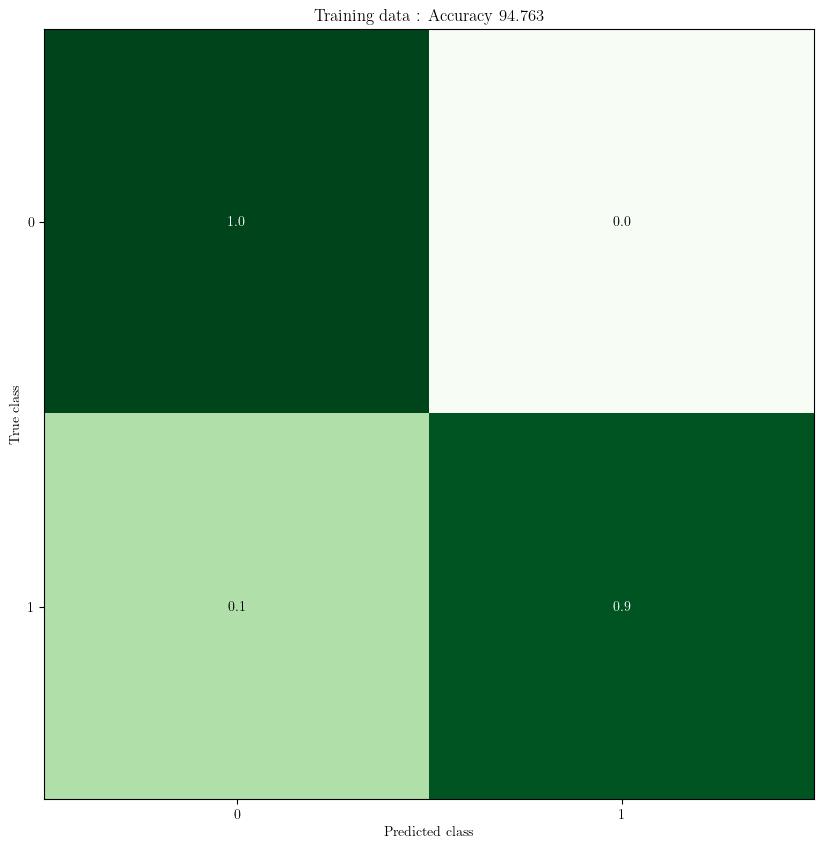

In [23]:
conf_matrix = np.zeros([2, 2])

for x,y in zip(Y_predict,Y):
    conf_matrix[int(y)][int(x)] +=1

    #Generate confusion matrix pdf
confusion_matrix.confusion_matrix(conf_matrix, figsize = (10,10), title = 'Training data',eval_labels = False)

This is the sofar best result for classification of faulty or nonfaulty case. None false positives while having acceptebel accuracy. Next: Does it work with validation data. Overfit is expected.

In [24]:
X_tst = test_data1.drop(['target'],axis=1)
Y_tst = test_data1['target']

[1 1 1 ... 1 1 1]


(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Training data : Accuracy 95.238%'}, xlabel='Predicted class', ylabel='True class'>)

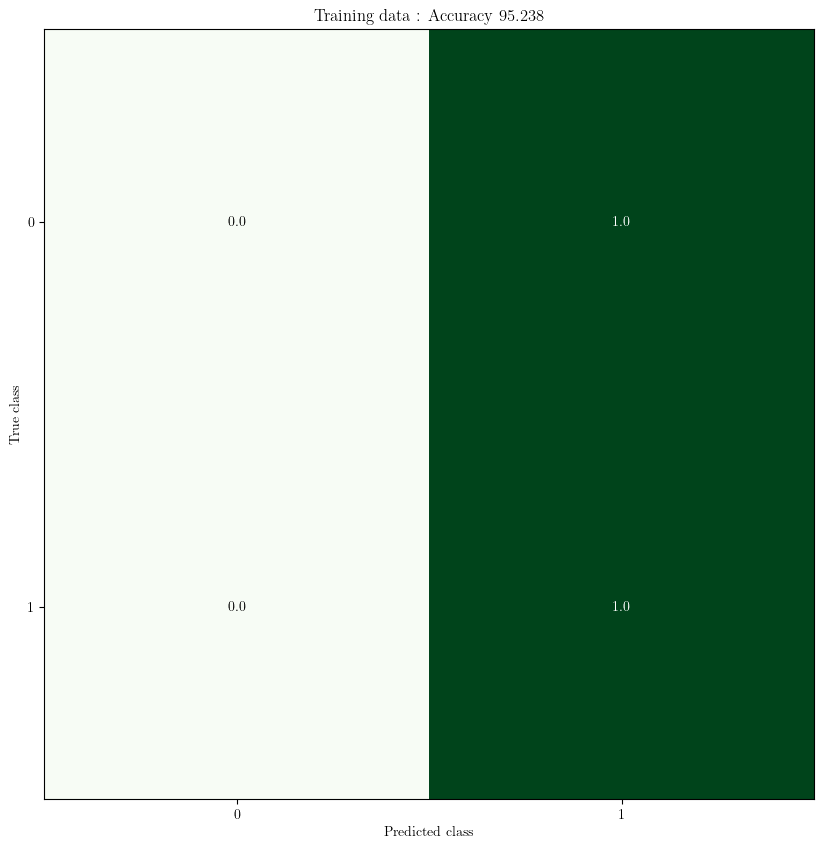

In [25]:
Y_tst_predict = clfBay.predict(X_tst)

print(Y_tst_predict)

conf_matrix = np.zeros([2, 2])

for x,y in zip(Y_tst_predict,Y_tst):
    conf_matrix[int(y)][int(x)] +=1

    #Generate confusion matrix pdf
confusion_matrix.confusion_matrix(conf_matrix, figsize = (10,10), title = 'Training data',eval_labels = False)


The expected overfit is a reality. ;)

## PCA for dimensionality reduction, to x dimensions, herafter MLC.

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Confusion matrix : Accuracy 54.863%'}, xlabel='Predicted class', ylabel='True class'>)

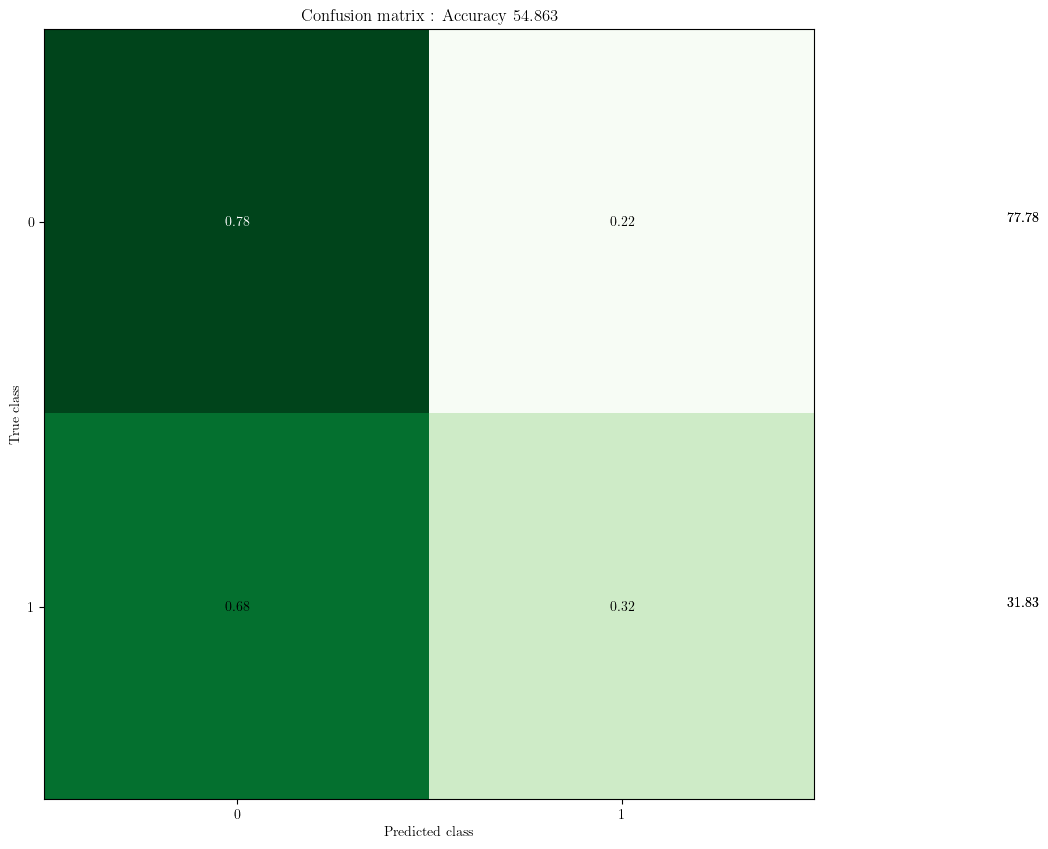

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

X_pca = pca.fit_transform(X,Y)


clfPCABay = bay.classifier()
clfPCABay.fit(X_pca,Y)
Y_predict = clfPCABay.predict(X_pca)

confusion_matrix2.confusion_matrix(Y,Y_predict)

In [213]:
X_tst_pca = pca.transform(X_tst)

Y_tst_predict = clfPCABay.predict(X_tst_pca)

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Confusion matrix : Accuracy 95.238%'}, xlabel='Predicted class', ylabel='True class'>)

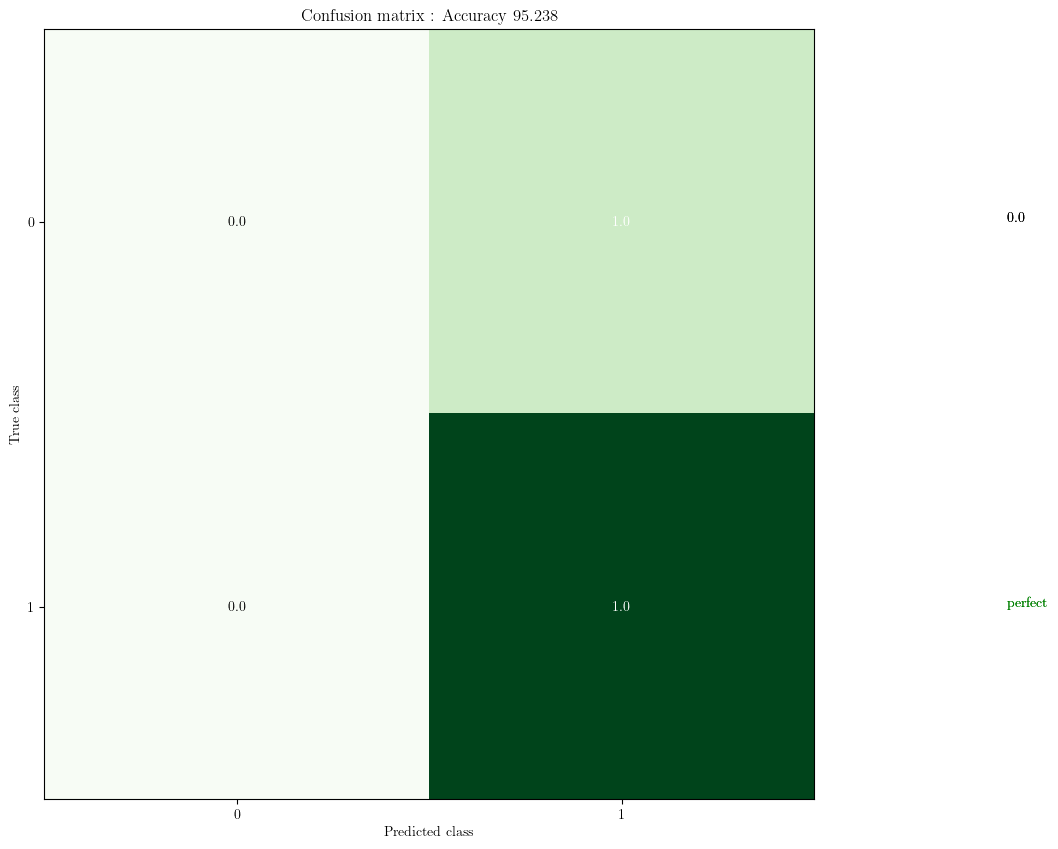

In [214]:

confusion_matrix2.confusion_matrix(Y_tst,Y_tst_predict)